# Baseline Travel Times

## 0 Setup environment

In [1]:
import os

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import pandas as pd

In [2]:
BASE_PATH = "data"
BOUNDARIES_FILE = os.path.join(BASE_PATH, "boundaries.gpkg")
MERGED_NETWORK_FILE = os.path.join(BASE_PATH, "merged_network_simplified.graphml")
TOWN_CENTERS_FILE = os.path.join(BASE_PATH, "town_centers.csv")

# Coordinates of the relief center at DSWD Field Office V
ORIGIN_COORDINATES = {"lat": 13.167815977098387, "lon": 123.75239324178186}

## 1 Load and visualize town center coordinates

In [3]:
df_town_centers = pd.read_csv(TOWN_CENTERS_FILE, usecols=["town", "province", "lat", "lon"])
df_town_centers = df_town_centers.dropna()
df_town_centers.head()

,town,province,lat,lon
0,Bacacay,Albay,13.294276,123.793023
1,Camalig,Albay,13.182025,123.655650
2,Daraga,Albay,13.149120,123.713038
3,Guinobatan,Albay,13.191479,123.599313
4,Jovellar,Albay,13.072732,123.598350


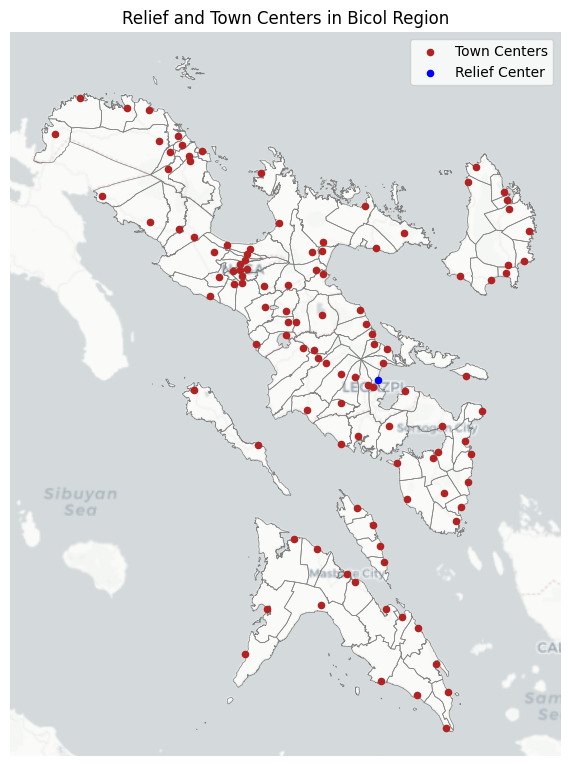

In [4]:
_, ax = plt.subplots(figsize=(8, 8))

gdf_boundaries = gpd.read_file(BOUNDARIES_FILE)
gdf_boundaries.plot(ax=ax, edgecolor="gray", linewidth=0.5, facecolor="none")

ax.scatter(df_town_centers["lon"], df_town_centers["lat"], c="firebrick", s=20, label="Town Centers")
ax.scatter(ORIGIN_COORDINATES["lon"], ORIGIN_COORDINATES["lat"], c="blue", s=20, label="Relief Center")

x_min, y_min, x_max, y_max = gdf_boundaries.total_bounds
padding = 0.1
ax.set_xlim(x_min - padding, x_max + padding)
ax.set_ylim(y_min - padding, y_max + padding)

cx.add_basemap(ax, crs=gdf_boundaries.crs, source=cx.providers.CartoDB.Positron, attribution="")

plt.title("Relief and Town Centers in Bicol Region")
plt.tight_layout()
plt.axis("off")
plt.legend(loc="upper right")

filepath = os.path.join(BASE_PATH, "town_centers.png")
plt.savefig(filepath, dpi=300, bbox_inches="tight")

plt.show()

## 2 Reclassify roads and assign speed limits

In [5]:
def reclassify_road(highway_attr):
    road_type = str(highway_attr)

    if road_type.endswith("_link"):
        road_type = road_type.replace("_link", "")

    if road_type in ["trunk", "primary"]:
        return "National Primary"
    elif road_type == "secondary":
        return "National Secondary"
    elif road_type == "tertiary":
        return "Provincial/Municipal"
    else:
        return "Barangay/Crowded"


def add_speed_and_segment_time(graph):
    # See R.A. 4136 for Philippine road speed limits.
    speed_limits_kmh = {
        "National Primary": 50,
        "National Secondary": 50,
        "Provincial/Municipal": 30,
        "Barangay/Crowded": 20,
        "ferry": 33.7,
    }

    highway_attrs = {}
    maxspeed_attrs = {}
    segment_time_attrs = {}

    for u, v, key, data in graph.edges(keys=True, data=True):
        edge = (u, v, key)
        mode = data.get("mode", "road")
        length_m = data["length"]
        speed_kmh = 0

        if mode == "road":
            highway_type = data.get("highway", "unclassified")
            road_category = reclassify_road(highway_type)
            highway_attrs[edge] = road_category

            speed_kmh = speed_limits_kmh[road_category]
            maxspeed_attrs[edge] = speed_kmh
        else:
            highway_attrs[edge] = "ferry"
            speed_kmh = speed_limits_kmh["ferry"]
            maxspeed_attrs[edge] = speed_kmh

        if speed_kmh > 0:
            segment_time = (length_m / 1000) / speed_kmh * 60
            segment_time_attrs[edge] = segment_time

    nx.set_edge_attributes(graph, highway_attrs, "highway")
    nx.set_edge_attributes(graph, maxspeed_attrs, "maxspeed")
    nx.set_edge_attributes(graph, segment_time_attrs, "segment_time")

    return graph

In [6]:
graph_transport = ox.load_graphml(MERGED_NETWORK_FILE)
graph_transport_weighted = add_speed_and_segment_time(graph_transport.copy())

gdf_transport_edges = ox.graph_to_gdfs(graph_transport_weighted, nodes=False, edges=True).reset_index()
gdf_transport_edges.groupby("highway").agg({"segment_time": "mean", "length": "mean"})

,segment_time,length
highway,,
Barangay/Crowded,0.607657,202.552363
National Primary,0.344122,286.768579
National Secondary,0.414054,345.045236
Provincial/Municipal,0.831879,415.939677
ferry,3.988273,2240.079754


In [7]:
filepath = os.path.join(BASE_PATH, "merged_network_weighted.graphml")
ox.save_graphml(graph_transport_weighted, filepath)

## 3 Find nearest network nodes

In [8]:
df_town_centers["origin_node"] = ox.nearest_nodes(
    graph_transport_weighted,
    X=[ORIGIN_COORDINATES["lon"]],
    Y=[ORIGIN_COORDINATES["lat"]],
)[0]

df_town_centers["destination_node"] = ox.nearest_nodes(
    graph_transport,
    X=df_town_centers["lon"],
    Y=df_town_centers["lat"],
)

df_town_centers.head()

,town,province,lat,lon,origin_node,destination_node
0,Bacacay,Albay,13.294276,123.793023,7700895122,1072640482
1,Camalig,Albay,13.182025,123.655650,7700895122,3958193431
2,Daraga,Albay,13.149120,123.713038,7700895122,9128688734
3,Guinobatan,Albay,13.191479,123.599313,7700895122,1746976936
4,Jovellar,Albay,13.072732,123.598350,7700895122,5952690700


## 4 Compute travel time from origin to all town centers

In [9]:
travel_times = nx.single_source_dijkstra_path_length(
    graph_transport_weighted,
    source=df_town_centers["origin_node"][0],
    weight="segment_time",
)

df_town_centers["travel_time"] = df_town_centers["destination_node"].map(travel_times)

In [10]:
missing_travel_times = df_town_centers["travel_time"].isna()

if missing_travel_times.any():
    print(df_town_centers[missing_travel_times][["town", "province", "destination_node"]])
    raise ValueError("Some travel times could not be calculated. Check the nodes.")

In [11]:
print("\n--- Fastest to Reach Town Centers ---")
cols = ["town", "province", "travel_time"]
df_town_centers[cols].sort_values("travel_time").head(10)


--- Fastest to Reach Town Centers ---


,town,province,travel_time
5,Legazpi City,Albay,6.636242
2,Daraga,Albay,8.232893
15,Santo Domingo,Albay,11.975125
1,Camalig,Albay,17.423472
8,Malilipot,Albay,22.400124
0,Bacacay,Albay,22.722983
3,Guinobatan,Albay,25.559240
16,Tabaco City,Albay,28.082637
9,Malinao,Albay,34.188701
7,Ligao City,Albay,37.512479


In [12]:
print("\n--- Slowest to Reach Town Centers ---")
df_town_centers[cols].sort_values("travel_time", ascending=False).head(10)


--- Slowest to Reach Town Centers ---


,town,province,travel_time
27,Santa Elena,Camarines Norte,315.355481
86,Esperanza,Masbate,308.415156
19,Capalonga,Camarines Norte,308.005522
93,Pio V. Corpus,Masbate,283.318495
94,Placer,Masbate,275.755182
22,Jose Panganiban,Camarines Norte,266.221596
25,Paracale,Camarines Norte,265.173561
82,Cataingan,Masbate,262.654251
80,Balud,Masbate,253.634342
83,Cawayan,Masbate,247.378937


In [13]:
filepath = os.path.join(BASE_PATH, "travel_times.csv")
df_town_centers.to_csv(filepath, index=False)

/tmp/ipykernel_18827/324302734.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma")
/home/ainz/Code/transport-network-analysis/.venv/lib64/python3.13/site-packages/osmnx/plot.py:351: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(od_x, od_y, s=orig_dest_size, c=route_color, alpha=route_alpha, edgecolor="none")


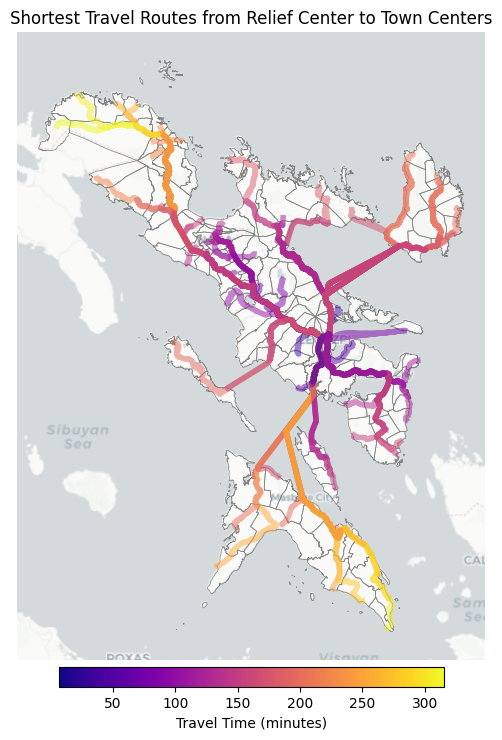

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import networkx as nx
import osmnx as ox


def plot_shortest_paths(G, df_routes, ax):
    """
    Plots the shortest paths from a single origin to multiple destinations,
    coloring each path by its travel time.
    """
    routes = []
    travel_times = []

    # Calculate shortest path for each town center
    for _, row in df_routes.iterrows():
        origin_node = row["origin_node"]
        dest_node = row["destination_node"]
        try:
            route = nx.shortest_path(G, source=origin_node, target=dest_node, weight="segment_time")
            routes.append(route)
            travel_times.append(row["travel_time"])
        except nx.NetworkXNoPath:
            # Skip towns with no path from the origin
            continue

    # Create a color map based on travel times
    if not travel_times:
        return  # Exit if no routes were found

    min_time = min(travel_times)
    max_time = max(travel_times)
    norm = colors.Normalize(vmin=min_time, vmax=max_time)
    cmap = cm.get_cmap("plasma")
    route_colors = [cmap(norm(time)) for time in travel_times]

    # Plot the routes on the map
    ox.plot_graph_routes(
        G, routes, route_colors=route_colors, route_linewidth=1.5, node_size=0, ax=ax, show=False, close=False
    )

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation="horizontal", pad=0.01, shrink=0.5)
    cbar.set_label("Travel Time (minutes)")


# --- Plot the final map ---
fig, ax = plt.subplots(figsize=(8, 8))

# Plot underlying boundaries
gdf_boundaries = gpd.read_file(BOUNDARIES_FILE)
gdf_boundaries.plot(ax=ax, edgecolor="gray", linewidth=0.5, facecolor="none", zorder=2)

# Plot the shortest path routes
plot_shortest_paths(graph_transport_weighted, df_town_centers, ax=ax)

# Add basemap
cx.add_basemap(ax, crs=gdf_boundaries.crs, source=cx.providers.CartoDB.Positron, attribution="", zorder=1)

# Finalize plot
ax.set_title("Shortest Travel Routes from Relief Center to Town Centers")
ax.set_axis_off()
plt.tight_layout()

# Save and show the figure
filepath = os.path.join(BASE_PATH, "shortest_paths_map.png")
plt.savefig(filepath, dpi=300, bbox_inches="tight")
plt.show()